In [4]:
%matplotlib inline
from matplotlib import pylab as plt

from metatlas import h5_query
from metatlas import metatlas_objects

import glob, os

import numpy as np

import tables


In [9]:
%system ls -t /project/projectdirs/metatlas/data_for_metatlas_2/

['m6Astandards_FRESH',
 'm6AMSMS',
 'm6AStandards',
 'm6A_Set1',
 'm6A_FinalSet',
 '20150504_LPSilva_Actino_HILIC_POS_51isolates',
 '20150324_LPSilva_BHedlund_chloroflexi_POS_rerun']

In [8]:
myPath = '/project/projectdirs/metatlas/data_for_metatlas_2/m6A_FinalSet/'
# myPath = '/project/projectdirs/metatlas/data_for_metatlas_2/m6AMSMS/'
# myPath = '/project/projectdirs/metatlas/data_for_metatlas_2/m6Astandards_FRESH/'
# # myPath = '/project/projectdirs/metatlas/data_for_metatlas_2/m6A_Set1/'
# # myPath = '/project/projectdirs/metatlas/data_for_metatlas_2/m6AStandards/'
myFiles = glob.glob('%s*.mzML'%myPath)
myFiles.sort()
for f in myFiles:
    print f
    metatlas_objects.mzml_to_hdf('%s'%(f))

/project/projectdirs/metatlas/data_for_metatlas_2/m6A_FinalSet/20150824_C18_POS_MSMS_ACN_Kin150mm_A1_Arabidopsis_DNA_1_R25_2ul.mzML


In [7]:
%system ls $myPath

['test.h5', 'test.mzML']

In [65]:
c1 = metatlas_objects.Compound(name = '2''-deoxyadenosine', 
                               formula = 'C10H13N5O3', 
                               adducts = 'H+', 
                               mz = 252.109115, 
                               mz_threshold = 15,
                               rt_min = 2.5, 
                               rt_max = 2.8, 
                               rt_peak = 2.65,
                               neutral_mass = 251.101839,
                               pubchem_id = 13730)

c2 = metatlas_objects.Compound(name = 'N6-Methyl-2''-deoxyadenosine', 
                               formula = 'C11H15N5O3', 
                               adducts = 'H+', 
                               mz = 266.124765, 
                               mz_threshold = 15,
                               rt_min = 2.7, 
                               rt_max = 3.0, 
                               rt_peak = 2.85,
                               neutral_mass = 265.117489,
                               pubchem_id = 168948 )

In [66]:
myPath = '/project/projectdirs/metatlas/data_for_metatlas_2/m6AMSMS/'
myfile = '20150828_C18_POS_MSMS_ACN_Kin150mm_C4_Chlamy_DNA_4_R4_8ul_MSMS_thegoodone.h5'
msms_chlamy_file = '%s%s' % (myPath,myfile)

myfile = '20150828_C18_POS_MSMS_ACN_Kin150mm_A1_Arabidopsis_DNA_1_R25_8ul_MSMS.h5'
msms_arab_file = '%s%s' % (myPath,myfile)

myfile = '20150828_C18_POS_MSMS_ACN_Kin150mm_N1_Nanochloropsis_DNA_1_R31_8ul_MSMS.h5'
msms_nanno_file = '%s%s' % (myPath,myfile)


myfile = '20150828_C18_POS_MSMS_ACN_Kin150mm__pt_1_ugmL__8ul.h5'
msms_reference_file = '%s%s' % (myPath,myfile)

myPath = '/project/projectdirs/metatlas/data_for_metatlas_2/m6A_FinalSet/'

flist = ['20150824_C18_POS_MSMS_ACN_Kin150mm_A1_Arabidopsis_DNA_1_R25_8ul.h5',
        '20150824_C18_POS_MSMS_ACN_Kin150mm_A2_Arabidopsis_DNA_2_R26_8ul.h5',
        '20150824_C18_POS_MSMS_ACN_Kin150mm_A3_Arabidopsis_DNA_3_R27_8ul.h5']

arabidopsis_files = []
for myfile in flist:
    arabidopsis_files.append('%s%s' % (myPath,myfile) )


flist = ['20150824_C18_POS_MSMS_ACN_Kin150mm_C1_Chlamy_DNA_1_R1_8ul.h5',
         '20150824_C18_POS_MSMS_ACN_Kin150mm_C2_Chlamy_DNA_2_R2_8ul.h5',
         '20150824_C18_POS_MSMS_ACN_Kin150mm_C3_Chlamy_DNA_3_R3_8ul.h5',
         '20150824_C18_POS_MSMS_ACN_Kin150mm_C4_Chlamy_DNA_4_R4_8ul.h5']

chlamy_files = []
for myfile in flist:
    chlamy_files.append('%s%s' % (myPath,myfile) )


flist = '20150824_C18_POS_MSMS_ACN_Kin150mm_N1_Nanochloropsis_DNA_1_R31_8ul.h5'
nanochloropsis_files = '%s%s' % (myPath,flist)


In [13]:
# Define a function to help us get 
# MS1 EIC data
# get spectrum near RT-peak
# Get MSMS data for each compound
# get MS1 data and summarize the datapoints
# get heatmap
def get_XIC(h5file, min_mz, max_mz, ms_level, polarity, bins=None, **kwargs):
    """
    Get Extracted-ion chromatogram (XIC) data - RT vs. cum sum of intensities

    Parameters
    ----------
    h5file : table file handle
        Handle to an open tables file.
    min_mz : float
        Minimum m/z value.
    max_mz : float
        Maximum m/z value.
    ms_level : int
        MS Level.
    polarity: int
        Plus proton (1) or Minus proton (0).
    bins : int or array-like, optional.
        Desired bins to use for the histogram, defaults to unique retention
        times.
    **kwargs
        Optional search modifiers.  (e.g. precursor_MZ=1,
            min_collision_energy=4)

    Returns
    -------
    out : tuple of arrays
        (rt_vals, i_vals) arrays in the desired range.  The intensities are
        scaled to [0, 100].
    """
    import metatlas

    data = metatlas.get_data(h5file, ms_level, polarity, min_mz=min_mz,
                    max_mz=max_mz, **kwargs)

    if bins is None:
        bins = np.unique(data['rt'])

    i, rt = np.histogram(data['rt'], bins=bins, weights=data['i'])
    # center the bins
    rt = (rt[:-1] + rt[1:]) / 2

    return rt, i

def get_data_for_a_compound(compound,what_to_get,h5file,polarity):
    """
    A helper function to query the various metatlas data selection 
    commands for a compound defined in an experimental atlas.

    Parameters
    ----------
    compound : a MetAtlas Object for a Compound Class
        this contains the m/z and retention time constraints to select data
    what_to_get : a list of strings
        this contains one or more of [ 'ms1_summary', 'eic', '2dhist', 'msms' ]
    h5_file : str
        Path to input_file
    polarity : int
        [0 or 1] for negative or positive ionzation
    
    Returns
    -------
    """
    #TODO : polarity should be handled in the experiment and not a loose parameter
    import numpy as np
    import metatlas
    import tables
    
    #get a pointer to the hdf5 file
    fid = tables.open_file(h5file)

    #parse varaiables from the metatlas compound object
    name = compound.name
    formula = compound.formula
    adducts = compound.adducts
    mz_theor = compound.mz
    ppm_uncertainty = compound.mz_threshold
    ms_level = 1
    rt_min = compound.rt_min
    rt_max = compound.rt_max
    mz_min = mz_theor - mz_theor * ppm_uncertainty / 1e6
    mz_max = mz_theor + mz_theor * ppm_uncertainty / 1e6
    
    return_data = {}
    return_data['compound'] = {}
    return_data['compound']['name'] = name
    return_data['compound']['formula'] = formula
    return_data['compound']['mz'] = mz_theor
    return_data['compound']['adducts'] = adducts
    
    if 'ms1_summary' in what_to_get:
        #Get Summary Data
        
        #First get MS1 Raw Data
        ms_level=1
        ms1_data = metatlas.get_data(fid, 
                                 ms_level,
                                 polarity,
                                 min_mz=mz_min,
                                 max_mz=mz_max,
                                 min_rt=rt_min,
                                 max_rt=rt_max)
        
        return_data['ms1_summary'] = {}
        return_data['ms1_summary']['mz_centroid'] = np.sum(np.multiply(ms1_data['i'],ms1_data['mz'])) / np.sum(ms1_data['i'])
        return_data['ms1_summary']['rt_centroid'] = np.sum(np.multiply(ms1_data['i'],ms1_data['rt'])) / np.sum(ms1_data['i'])
        idx = np.argmax(ms1_data['i'])
        return_data['ms1_summary']['mz_max'] = ms1_data['mz'][idx]
        return_data['ms1_summary']['rt_max'] = ms1_data['rt'][idx]        
        return_data['ms1_summary']['peak_height'] = ms1_data['i'][idx]
        return_data['ms1_summary']['peak_area'] = np.sum(ms1_data['i'])
    
    if 'eic' in what_to_get:
        #Get Extracted Ion Chromatogram
        # TODO : If a person calls for summary, then they will already have the MS1 raw data
        rt,intensity = get_XIC(fid, 
                                        mz_min, 
                                        mz_max,
                                        ms_level,
                                        polarity)
        return_data['eic'] = {}
        return_data['eic']['rt'] = rt
        return_data['eic']['intensity'] = intensity
    
    if '2dhist' in what_to_get:
        #Get 2D histogram of intensity values in m/z and retention time
        mzEdges = np.logspace(np.log10(100),np.log10(1000),10000)
#         mzEdges = np.linspace(mz_theor - 3, mz_theor + 30,100) #TODO : number of mz bins should be an optional parameter
        rtEdges = np.linspace(rt_min,rt_max,100) #TODO : number of rt bins should be an optional parameter. When not provided, it shoulddefauly to unique bins
        ms_level = 1 #TODO : ms_level should be a parameter
        return_data['2dhist'] = {}
        return_data['2dhist'] = metatlas.get_heatmap(fid,mzEdges,rtEdges,ms_level,polarity)
    
    if 'msms' in what_to_get:
        #Get Fragmentation Data
        ms_level=2
        fragmentation_data = metatlas.get_data(fid, 
                                 ms_level,
                                 polarity,
                                 min_mz=0,
                                 max_mz=mz_theor+10,#TODO : this needs to be a parameter
                                 min_rt=rt_min,
                                 max_rt=rt_max,
                                 min_precursor_MZ=mz_min-0.01,
                                 max_precursor_MZ=mz_max+0.01)
    #                     min_precursor_intensity=0, #TODO : this needs to be a parameter
    #                     max_precursor_intensity=0,#TODO : this needs to be a parameter
    #                     min_collision_energy=0,#TODO : this needs to be a parameter
    #                     max_collision_energy=0)#TODO : this needs to be a parameter
        return_data['msms'] = fragmentation_data

    return return_data

In [14]:
reference_data = get_data_for_a_compound(c2,['ms1_summary','msms','eic'],msms_reference_file,1)
chlamy_data = get_data_for_a_compound(c2,['ms1_summary','msms','eic'],msms_chlamy_file,1)
arab_data = get_data_for_a_compound(c2,['ms1_summary','msms','eic'],msms_arab_file,1)
nanno_data = get_data_for_a_compound(c2,['ms1_summary','msms','eic'],msms_nanno_file,1)



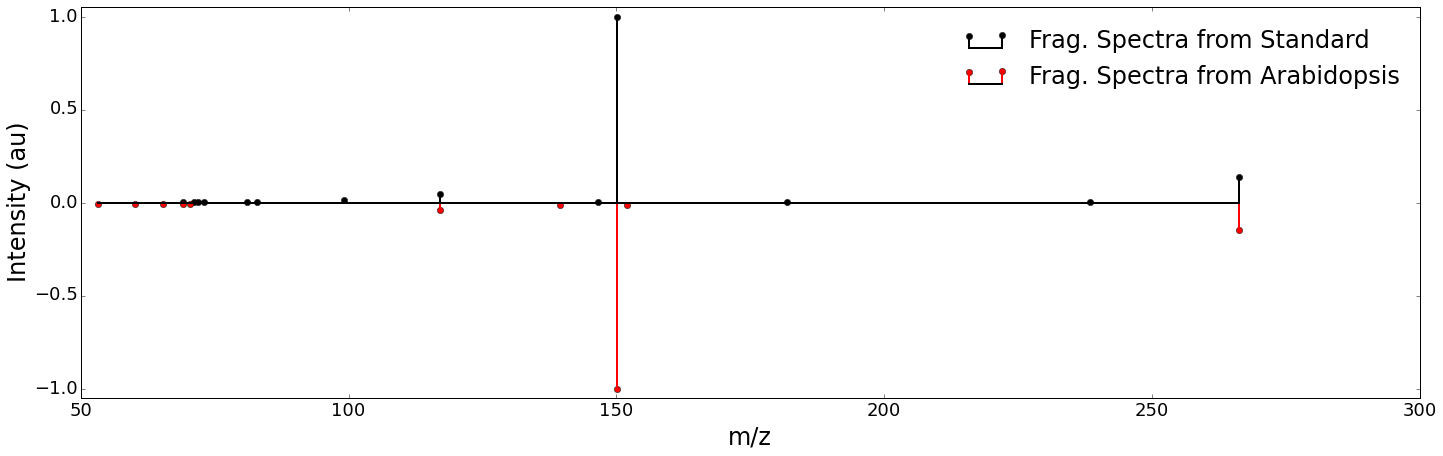

In [15]:
# create a new plot with a title and axis labels
f = plt.figure(num=None, figsize=(24, 7), dpi=300, facecolor='w', edgecolor='k')

# x = data['msms']['mz']
# y0 = np.zeros(data['msms']['i'].shape)
# y =  data['msms']['i']
key = 'msms'
data = reference_data
x = data[key]['mz']
y0 = np.zeros(data[key]['i'].shape)
y =  data[key]['i']
y = y / max(y)

markerline, stemlines, baseline = plt.stem(x,y,'-',label='Frag. Spectra from Standard')
plt.setp(markerline, 'markerfacecolor', 'k')
plt.setp(baseline, 'color','k', 'linewidth', 2)
plt.setp(stemlines, 'color','k', 'linewidth', 2)

data = arab_data
x = data[key]['mz']
y0 = np.zeros(data[key]['i'].shape)
y =  data[key]['i']
y = -1* y / max(y)


markerline, stemlines, baseline = plt.stem(x, y, '-',label='Frag. Spectra from Arabidopsis')
plt.setp(markerline, 'markerfacecolor', 'r')
plt.setp(baseline, 'color','k', 'linewidth', 2)
plt.setp(stemlines, 'color','r', 'linewidth', 2)
# plt.setp(baseline, 'color','r', 'linewidth', 3)

plt.ylim(-1.05,1.05)
plt.xlim(50,300)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.ylabel('Intensity (au)',size=24)
plt.xlabel('m/z',size=24)
lg = plt.legend(loc = 'upper right',fontsize = 24)
lg.draw_frame(False)
plt.show()
f.savefig('6MA_Reference To Arabidopsis MSMS.pdf')


In [16]:
reference_data = get_data_for_a_compound(c1,['ms1_summary','msms','eic'],msms_reference_file,1)
chlamy_data = get_data_for_a_compound(c1,['ms1_summary','msms','eic'],msms_chlamy_file,1)


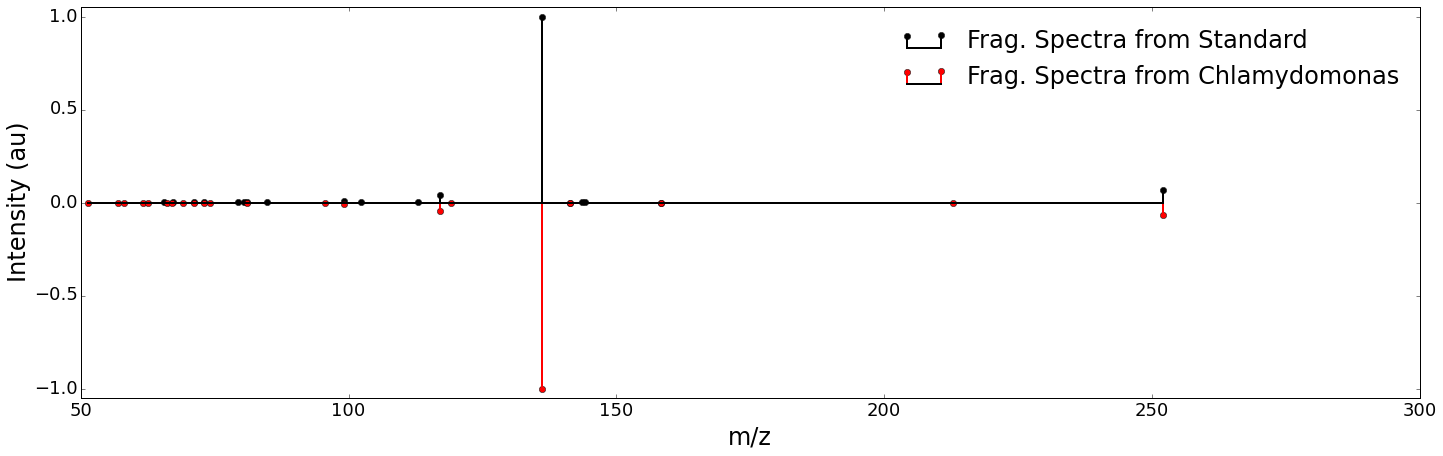

In [17]:
# create a new plot with a title and axis labels
f = plt.figure(num=None, figsize=(24, 7), dpi=300, facecolor='w', edgecolor='k')

# x = data['msms']['mz']
# y0 = np.zeros(data['msms']['i'].shape)
# y =  data['msms']['i']
key = 'msms'
data = reference_data
x = data[key]['mz']
y0 = np.zeros(data[key]['i'].shape)
y =  data[key]['i']
y = y / max(y)

markerline, stemlines, baseline = plt.stem(x,y,'-',label='Frag. Spectra from Standard')
plt.setp(markerline, 'markerfacecolor', 'k')
plt.setp(baseline, 'color','k', 'linewidth', 2)
plt.setp(stemlines, 'color','k', 'linewidth', 2)

data = chlamy_data
x = data[key]['mz']
y0 = np.zeros(data[key]['i'].shape)
y =  data[key]['i']
y = -1* y / max(y)


markerline, stemlines, baseline = plt.stem(x, y, '-',label='Frag. Spectra from Chlamydomonas')
plt.setp(markerline, 'markerfacecolor', 'r')
plt.setp(baseline, 'color','k', 'linewidth', 2)
plt.setp(stemlines, 'color','r', 'linewidth', 2)
# plt.setp(baseline, 'color','r', 'linewidth', 3)

plt.ylim(-1.05,1.05)
plt.xlim(50,300)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.ylabel('Intensity (au)',size=24)
plt.xlabel('m/z',size=24)
lg = plt.legend(loc = 'upper right',fontsize = 24)
lg.draw_frame(False)
plt.show()
f.savefig('deoxyA_Reference To Chlamy MSMS.pdf')


In [67]:
chlamy_data = []
for f in chlamy_files:
    chlamy_data.append(get_data_for_a_compound(c2,['ms1_summary','eic'],f,1))

arabidopsis_data = []
for f in arabidopsis_files:
    arabidopsis_data.append(get_data_for_a_compound(c2,['ms1_summary','eic'],f,1))

nanochloropsis_data = []
nanochloropsis_data.append(get_data_for_a_compound(c2,['ms1_summary','eic'],nanochloropsis_files,1))

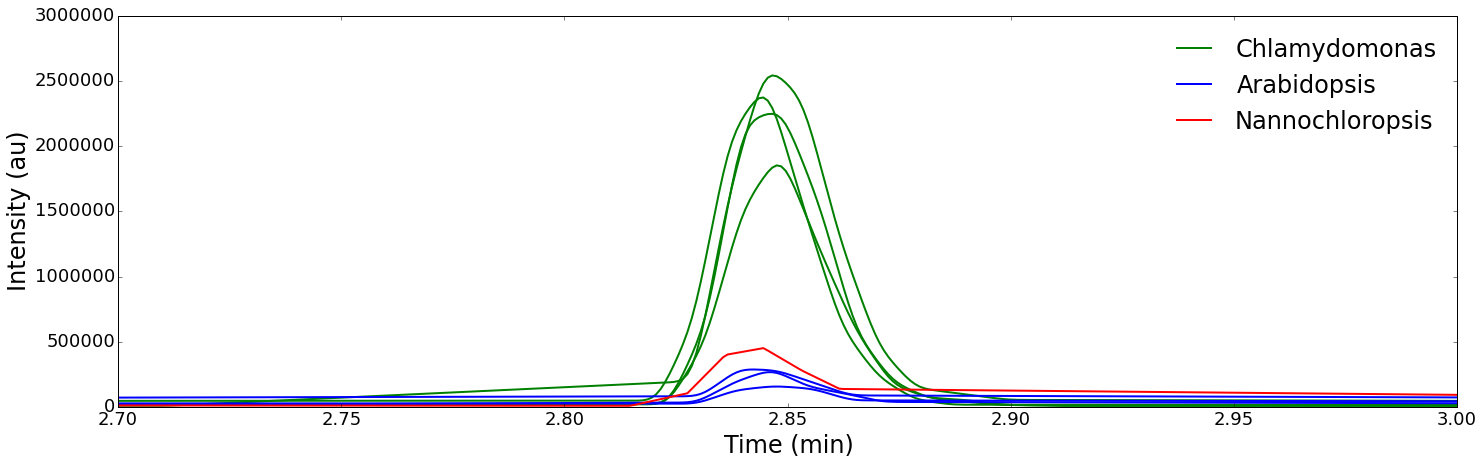

In [68]:
from scipy.signal import resample
GAUSS_WIDTH = 1 #ppm


x = np.linspace(-3*GAUSS_WIDTH,3*GAUSS_WIDTH,1 + 6*MZ_GAUSS_WIDTH / 0.5)
fi=np.exp(-0.5*((x)/MZ_GAUSS_WIDTH)**2)
fi = fi / sum(fi)

# filt_spectrum = np.convolve(TOTALSPECTRUM,f,'same')

f = plt.figure(num=None, figsize=(24, 7), dpi=300, facecolor='w', edgecolor='k')
for d in chlamy_data:
    x = np.linspace(0,5,5/0.001)
    y = np.interp(x,d['eic']['rt'],d['eic']['intensity'])
    sy = np.convolve(y[:],fi[:],'same')
    plt.plot(x,sy,'-',color='green',markersize=20,label='Chlamydomonas',linewidth=2)
for d in arabidopsis_data:
    x = np.linspace(0,5,5/0.001)
    y = np.interp(x,d['eic']['rt'],d['eic']['intensity'])
    sy = np.convolve(y[:],fi[:],'same')
    plt.plot(x,sy,'-',color='blue',markersize=20,label='Arabidopsis',linewidth=2)
for d in nanochloropsis_data:
    x = np.linspace(0,5,5/0.001)
    y = np.interp(x,d['eic']['rt'],d['eic']['intensity'])
    sy = np.convolve(y[:],fi[:],'same')
    plt.plot(x,y,'-',color='red',markersize=20,label='Nannochloropsis',linewidth=2)
plt.xlim(c2.rt_min,c2.rt_max)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.ylabel('Intensity (au)',size=24)
plt.xlabel('Time (min)',size=24)
from collections import OrderedDict
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
lg = plt.legend(by_label.values(), by_label.keys(),fontsize=24)
lg.draw_frame(False)

plt.show()
f.savefig('6-methyl-deoxyadenosine_chromatograms_zoom_out.pdf')

In [69]:
chlamy_data = []
for f in chlamy_files:
    chlamy_data.append(get_data_for_a_compound(c1,['ms1_summary','eic'],f,1))

arabidopsis_data = []
for f in arabidopsis_files:
    arabidopsis_data.append(get_data_for_a_compound(c1,['ms1_summary','eic'],f,1))

nanochloropsis_data = []
nanochloropsis_data.append(get_data_for_a_compound(c1,['ms1_summary','eic'],nanochloropsis_files,1))

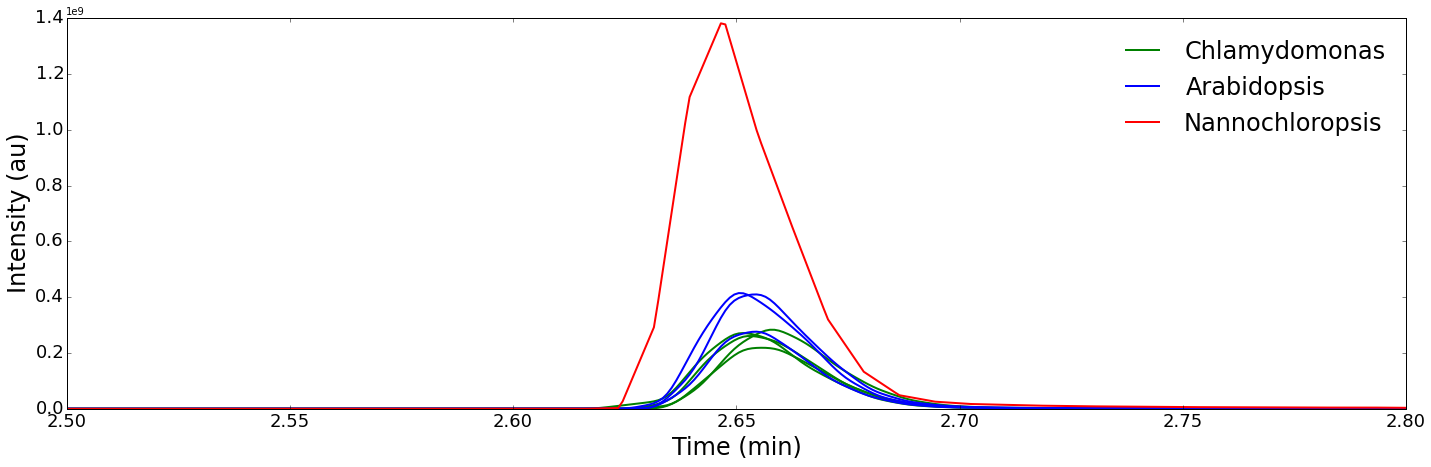

In [70]:
from scipy.signal import resample
GAUSS_WIDTH = 1 #ppm


x = np.linspace(-3*GAUSS_WIDTH,3*GAUSS_WIDTH,1 + 6*MZ_GAUSS_WIDTH / 0.5)
fi=np.exp(-0.5*((x)/MZ_GAUSS_WIDTH)**2)
fi = fi / sum(fi)

# filt_spectrum = np.convolve(TOTALSPECTRUM,f,'same')

f = plt.figure(num=None, figsize=(24, 7), dpi=300, facecolor='w', edgecolor='k')
for d in chlamy_data:
    x = np.linspace(0,5,5/0.001)
    y = np.interp(x,d['eic']['rt'],d['eic']['intensity'])
    sy = np.convolve(y[:],fi[:],'same')
    plt.plot(x,sy,'-',color='green',markersize=20,label='Chlamydomonas',linewidth=2)
for d in arabidopsis_data:
    x = np.linspace(0,5,5/0.001)
    y = np.interp(x,d['eic']['rt'],d['eic']['intensity'])
    sy = np.convolve(y[:],fi[:],'same')
    plt.plot(x,sy,'-',color='blue',markersize=20,label='Arabidopsis',linewidth=2)
for d in nanochloropsis_data:
    x = np.linspace(0,5,5/0.001)
    y = np.interp(x,d['eic']['rt'],d['eic']['intensity'])
    sy = np.convolve(y[:],fi[:],'same')
    plt.plot(x,y,'-',color='red',markersize=20,label='Nannochloropsis',linewidth=2)
plt.xlim(c1.rt_min,c1.rt_max)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.ylabel('Intensity (au)',size=24)
plt.xlabel('Time (min)',size=24)
from collections import OrderedDict
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
lg = plt.legend(by_label.values(), by_label.keys(),fontsize=24)
lg.draw_frame(False)

plt.show()
f.savefig('deoxyadenosine_chromatograms_zoom_out.pdf')

In [1]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [3]:
import os
filename = os.path.basename(NOTEBOOK_FULL_PATH)
%system cp $filename /project/projectdirs/openmsi/www/
temp = '%s/%s'%('/project/projectdirs/openmsi/www',filename)
%system chmod 775 $temp
print 'http://nbviewer.ipython.org/url/portal.nersc.gov/project/openmsi/%s?flush_cache=true'%filename

http://nbviewer.ipython.org/url/portal.nersc.gov/project/openmsi/Create_MSMS_Comparison_Experimental_Standard.ipynb?flush_cache=true
